In [ ]:
!pip install numpy
!pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 11.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630089 sha256=ef1dccc47d1b96e3fa8628c160e68952693de0812f4acc8c8f67a77e6d3535c7
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import surprise
from surprise import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.sparse import csr_matrix
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import KNNBasic,SVD
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV


# Dataset Analysis

In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/ml-20m/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ml-20m/ratings.csv')
data = pd.merge(left=movies, right=ratings, on='movieId')
reader = Reader(rating_scale=(0.5, 5.0))
# data = Dataset.load_from_df(data[['userId', 'movieId','rating']], reader)

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [ ]:
user,item,rating= data["userId"],data["movieId"],data["rating"]
max_user,max_item = user.nunique(),item.nunique()
max_rating,min_rating,avg_rating=rating.max(),rating.min(),rating.mean()
print("Number of user:->",max_user)
print("Number of item:->",max_item)
print("max rating :->",max_rating)
print("min rating:->",min_rating)
print("avg rating :->",avg_rating)
mean_ratings = data.groupby('userId')['rating'].mean()
meanofuser=mean_ratings.mean()
print("avg rating by user :->",meanofuser)


Number of user:-> 138493
Number of item:-> 26744
max rating :-> 5.0
min rating:-> 0.5
avg rating :-> 3.5255285642993797
avg rating by user :-> 3.627208621886526


 best movie by average rating

In [ ]:
mean_ratings = data.groupby('userId')[['rating']].mean()
best = mean_ratings['rating'].idxmax()
movies[movies['movieId']==best]


,movieId,title,genres
3267,3354,Mission to Mars (2000),Sci-Fi


number of geners and movies

In [ ]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
ge = Counter(g for genres in movies['genres'] for g in genres)
ge

Counter({'(no genres listed)': 246,
         'Action': 3520,
         'Adventure': 2329,
         'Animation': 1027,
         'Children': 1139,
         'Comedy': 8374,
         'Crime': 2939,
         'Documentary': 2471,
         'Drama': 13344,
         'Fantasy': 1412,
         'Film-Noir': 330,
         'Horror': 2611,
         'IMAX': 196,
         'Musical': 1036,
         'Mystery': 1514,
         'Romance': 4127,
         'Sci-Fi': 1743,
         'Thriller': 4178,
         'War': 1194,
         'Western': 676})

 The x-axis of the histogram denotes the number of bins while the y-axis represents the frequency of a particular bin.

 here in the histogram of rating we can clearly see that 4.5 is highest rated by users and average rating is aroung 3.5 and also we can observ that the users are more prone to give 5 star rather than 0.5

(array([ 239125.,  680732.,  279252., 1430997.,  883398., 4291193.,
        2200156., 5561926., 4433484.]),
 array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 9 Patch objects>)

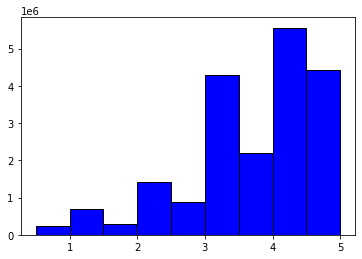

In [ ]:
plt.hist(data['rating'], bins=list(np.arange(0.5,5.5,0.5)), color='blue', ec='black')

# Normalization Techniques

crearting user-item matrix

because of the large amount of dataset can't convert into the sparse matrix

In [ ]:
# matrix=ratings.pivot(index='userId', columns='movieId', values='rating')
# M = ratings['userId'].nunique()
# N = ratings['movieId'].nunique()

# user_mapper = dict(zip(np.unique(ratings["userId"]), list(range(M))))
# movie_mapper = dict(zip(np.unique(ratings["movieId"]), list(range(N))))

# user_inv_mapper = dict(zip(list(range(M)), np.unique(ratings["userId"])))
# movie_inv_mapper = dict(zip(list(range(N)), np.unique(ratings["movieId"])))

# user_index = [user_mapper[i] for i in ratings['userId']]
# item_index = [movie_mapper[i] for i in ratings['movieId']]

# X = csr_matrix((ratings["rating"], (user_index,item_index)), shape=(M,N))

mean centering


In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/ml-20m/ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))

In [ ]:
mean_ratings = ratings.groupby(['userId'])['rating'].transform('mean')
ratings['mean_cent_rating'] = ratings['rating'] - mean_ratings
# ratings['rating']=ratings['mean_cent_rating']

In [ ]:
norm1_data=Dataset.load_from_df(ratings[['userId', 'movieId','rating']], reader)

In [ ]:
algo1=KNNBasic()
trainset, testset = train_test_split(ratings, test_size=0.2)

In [ ]:
algo1.fit(trainset)
predict=algo1.test(testset)

z-score

z-socre is more sensitive then the mean centering because in mean centring we only subtract the mean but here in the z-score we considering the standard deviation as well and we devide our mean centring rating by deviation so it give me more accurat normalization in compare to the mean rating.

In [ ]:
deviation = ratings.groupby(['userId'])['rating'].transform('std')
ratings['z-score'] = ratings['mean_cent_rating']/deviation

In [ ]:
norm2_data=Dataset.load_from_df(ratings[['userId', 'movieId','z-score']], reader)

In [ ]:
algo2=KNNBasic()
trainset, testset = train_test_split(norm2_data, test_size=0.2)
algo2.fit(trainset)
predict=algo2.test(testset)

because of large amount of data set can't fit the data into knn algo but our we can use svd algo it's shown in question 4.

RMSE and cross

In [ ]:
test_predictions =algo1.test(testset, verbose=False)
accuracy.rmse(test_predictions)

In [ ]:
param_grid = {'k': list(range(5, 20, 5))}
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(ratings)

plot

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(param_grid, gs, marker = 'o')
plt.title(plot, fontsize = 12)
plt.xlabel(k, fontsize = 10)
plt.ylabel(rmse, fontsize = 10)
plt.draw()

# Similarity Measures

a. Cosine Similarity

cosine similarity is standard technique to find similarity between two vectors so it is easy to find cosine similarity we just need to dot product and devides them by their norms.

In [ ]:
sim_options = {'name': 'cosine','user_based': False }
algo = KNNBasic(sim_options=sim_options)
trainset, testset = train_test_split(norm2_data, test_size=0.2)
algo.fit(trainset)
predict=algo.test(testset)
cross_validate(algo, norm1_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
predictions = algo.test(testset)
rmse=accuracy.rmse(predictions)

b. Pearson Correlation


pearson is same as coine similarity the only deference is it is use mean centring method to find similarity

In [ ]:
sim_options = {'name': 'pearson','user_based': False ,'shrinkage': 0 }
algo = KNNBasic(sim_options=sim_options)
trainset, testset = train_test_split(norm2_data, test_size=0.2)
algo.fit(trainset)
predict=algo.test(testset)
cross_validate(algo, norm1_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Adjusted Cosine

it is the more accurate in my opinion it is just like cos similarity but it is more sensitive then cos similarity it's taking direction also in consideration.

In [ ]:
mean_ratings = ratings.groupby(['userId'])['rating'].transform('mean')
ratings['mean_cent_rating'] = ratings['rating'] - mean_ratings

In [ ]:
movies_data =ratings.iloc[:50000,:]
moviemat = movies_data.pivot_table(index='userId', columns='movieId', values='mean_cent_rating').replace(np.nan,0)

In [ ]:
from scipy.spatial.distance import pdist, squareform
similarity= 1 - squareform(pdist(moviemat.T, 'cosine'))
sim=pd.DataFrame(similarity)

In [ ]:
algo = KNNBasic()
trainset, testset = train_test_split(sim, test_size=0.2)
algo.fit(trainset)
predict=algo.test(testset)
cross_validate(algo, norm1_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Factorization Techniques

the similarity matrix (using Eigen
Decomposition)

In [ ]:
from numpy.linalg import eig
value,vectors=eig(similarity)
sigma=np.fill_diagonal(value)
new=vectors*sigma*np.transpose(vectors)
algo = KNNBasic()
trainset, testset = train_test_split(new, test_size=0.2)
algo.fit(trainset)
predict=algo.test(testset)
cross_validate(algo, norm1_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

 the rating matrix (using Singular Value Decomposition) for the
assigned dataset

In [ ]:
trainset, testset = train_test_split(norm1_data, test_size=.25)
svd_model = SVD()
svd_model.fit(trainset)

In [ ]:
predictions = svd_model.test(testset)
accuracy.rmse(predictions)

RMSE: 0.7889


0.7888998937848528

In [ ]:
cross_validate(svd_model, norm1_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

here we do two type of matrix factorization one is using eigen decomposition and other one is svd bsically we can get svd is from eigen dec. only but in the ED we have the symmetric matrix like here we have similarity matrix which is symmetric but our general use-item (rating) matrix is not symmetric so that is why we have to use svd.so using this basically we did that we convert our sparse matrix into the dense and decrease the dimensionn of our matrix as well. so that is why in above dataset we can't fit knn algo but can fit svd algo so this is the usecase of MF.